In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["KERAS_BACKEND"] = "jax"
import keras

import numpy as np
import jax
from keras import ops

In [54]:
from distributions import ZeroInflatedDist, QuantizedNormal
from plotting_funcs import sample_and_plot, plot_dist, plot_hexagon_grid

In [3]:
consistent_4 = [QuantizedNormal(7, 0.1) for _ in range(4)]

highvar_4 = [ZeroInflatedDist(QuantizedNormal(10, 0.1), 1-0.7) for _ in range(4)]

powerball_4 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(4)]

dist_S = consistent_4 + highvar_4 +powerball_4
S=12

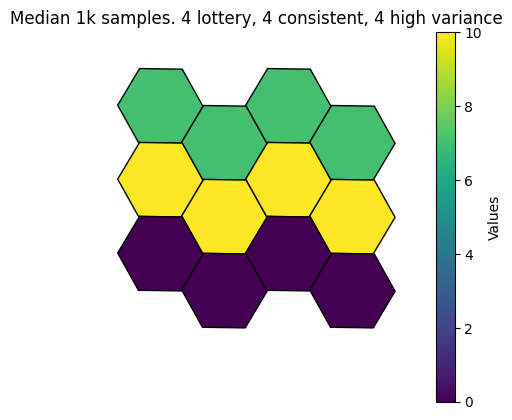

In [4]:
sample_and_plot(dist_S, size=1000, median=True, title='Median 1k samples. 4 lottery, 4 consistent, 4 high variance')

In [16]:
def make_training_data(dist_S, history=50, timepoints=10, seed=360):

    data_HT1_S = np.zeros((history+timepoints+1, S))
    for s, dist in enumerate(dist_S):
        random_state = np.random.RandomState(10000 * seed + s)
        data_HT1_S[:, s] = dist.rvs(size=history+timepoints+1, random_state=random_state)

    X_THS = np.array([data_HT1_S[t:history+t,:] for t in range(timepoints)])
    y_TS = np.array([data_HT1_S[history+1+t, :] for t in range(timepoints)])

    # reshape to be 2D
    X_T_HS = np.reshape(X_THS, (timepoints, history*S))

    return X_T_HS, y_TS

In [17]:
H=50
T=10
X_T_HS, y_TS = make_training_data(dist_S, history=H, timepoints=T, seed=360)

In [46]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(H*S,)),
        keras.layers.Dense(S, activation="softplus"),
    ]
)

In [47]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='poisson')

In [48]:
model.trainable_variables

[<KerasVariable shape=(600, 12), dtype=float32, path=sequential_3/dense_3/kernel>,
 <KerasVariable shape=(12,), dtype=float32, path=sequential_3/dense_3/bias>]

In [49]:
output = model(X_T_HS)

In [50]:
output.shape

(10, 12)

In [45]:
model.fit(X_T_HS, y_TS, epochs=1000,)

Epoch 1/1000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 55.7676
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 32.4263
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13.9586  
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1943  
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -3.7299  
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -7.5084  
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -9.7415  
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -11.4532  
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -12.5339  
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -13.0516  
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -13.5268  
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -14.1283  
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -14.8394  
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: -15.6325  
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

In [51]:
output = model(X_T_HS)

In [68]:
output.shape

(10, 12)

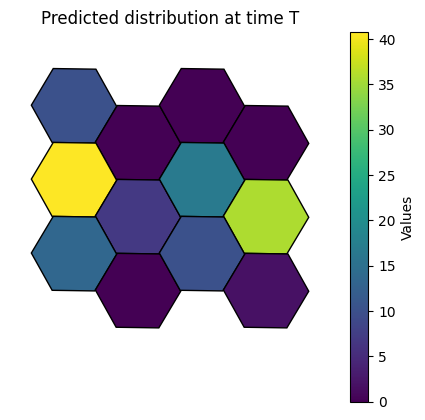

In [66]:
plot_hexagon_grid(output[3,:], title='Predicted distribution at time T')

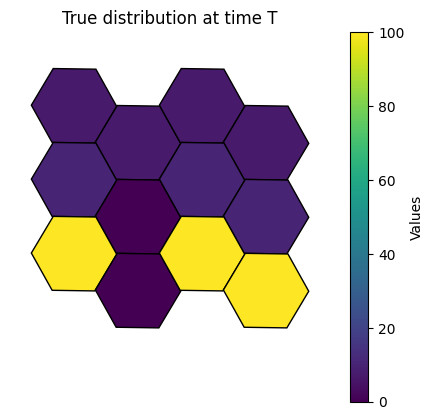

In [62]:
plot_hexagon_grid(y_TS[-7,:], title='True distribution at time T')